#**Deep Learning Homework 4: Recurrent Neural Networks & Transformer**

### MSc Computer Science, Data Science, Cybersecurity @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.  

##Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17473536/17464789 [==============================] - 0s 0us/step


Let's also get the word indexs (word to word-id)

In [3]:
word_index = keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [4]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [7]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

**[TO COMPLETE]** In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in `model.compile()` and motivate your choice.


Please, insert your answer in this text cell.

**Answer:** For the activation function I tried relu, elu, selu and tanh activations. All of the previous functions didn't result to satisfactory accuracy. After many trials the learning curve was not smooth and with multiple executions I realised that using the sigmoid activation function gave the best performance. This in combination with binary crossentropy for the loss, because we are handling a binary problem.

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [10]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 90s 437ms/step - loss: 0.6119 - accuracy: 0.6480 - val_loss: 0.4631 - val_accuracy: 0.7917
Epoch 2/10
196/196 [==============================] - 84s 429ms/step - loss: 0.3558 - accuracy: 0.8523 - val_loss: 0.3585 - val_accuracy: 0.8533
Epoch 3/10
196/196 [==============================] - 92s 470ms/step - loss: 0.3283 - accuracy: 0.8716 - val_loss: 0.3514 - val_accuracy: 0.8554
Epoch 4/10
196/196 [==============================] - 85s 435ms/step - loss: 0.2116 - accuracy: 0.9220 - val_loss: 0.3570 - val_accuracy: 0.8609
Epoch 5/10
196/196 [==============================] - 85s 435ms/step - loss: 0.1703 - accuracy: 0.9385 - val_loss: 0.3720 - val_accuracy: 0.8586
Epoch 6/10
196/196 [==============================] - 86s 437ms/step - loss: 0.1908 - accuracy: 0.9266 - val_loss: 0.4150 - val_accuracy: 0.8348
Epoch 7/10
196/196 [==============================] - 84s 428ms/step - loss: 0.1438 - accuracy: 0.9490 - val_loss: 0.4544 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 13s - loss: 0.6115 - accuracy: 0.8270 - 13s/epoch - 34ms/step
accuracy: 82.70%


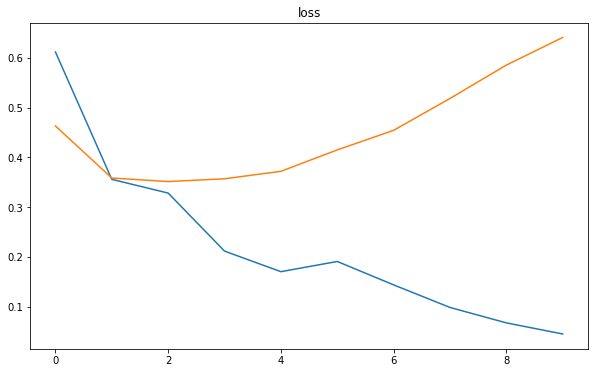

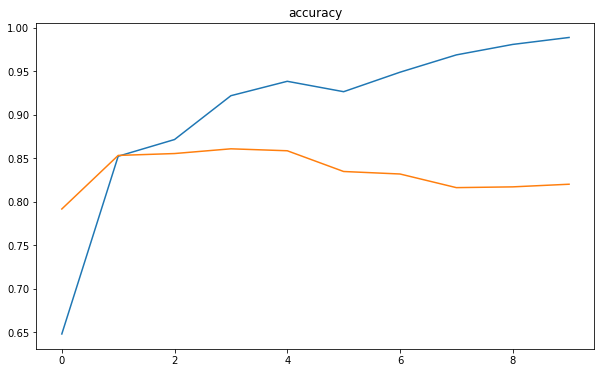

In [11]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm_6 (LSTM)               (None, 25)                3600      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 103,626
Trainable params: 103,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 4s 15ms/step - loss: 0.7584 - accuracy: 0.6480 - val_loss: 0.3920 - val_accuracy: 0.8400
Epoch 2/10
196/196 [==============================] - 2s 12ms/step - loss: 0.3347 - accuracy: 0.8629 - val_loss: 0.3535 - val_accuracy: 0.8584
Epoch 3/10
196/196 [======

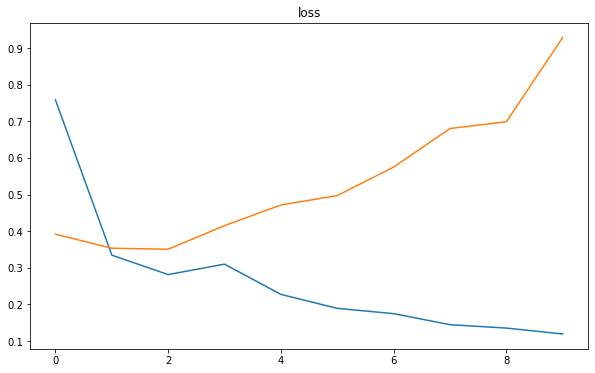

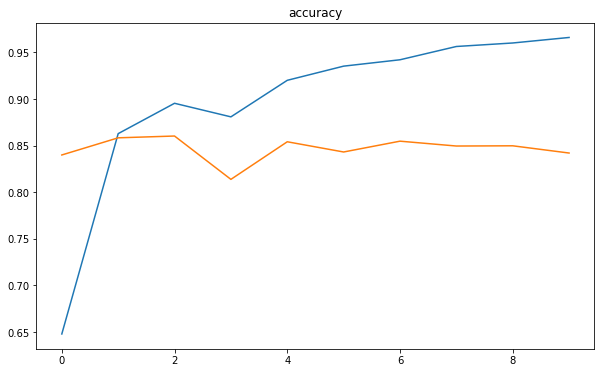

In [25]:
# LSTM - complete with model definition, summary, fit and plots.


model_lstm = keras.models.Sequential()
model_lstm.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_lstm.add(keras.layers.LSTM(25))
model_lstm.add(keras.layers.Dense(1, activation="tanh"))

model_lstm.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])


# Model summary

model_lstm.summary()


# Train the model

history = model_lstm.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

#Plot

plot_loss(history)

plot_accuracy(history)

scores = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 10)          100000    
                                                                 
 gru (GRU)                   (None, 25)                2775      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 102,801
Trainable params: 102,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 4s 15ms/step - loss: 0.7978 - accuracy: 0.6146 - val_loss: 0.5667 - val_accuracy: 0.7325
Epoch 2/10
196/196 [==============================] - 3s 13ms/step - loss: 0.4331 - accuracy: 0.8216 - val_loss: 0.4496 - val_accuracy: 0.8234
Epoch 3/10
196/196 [=====

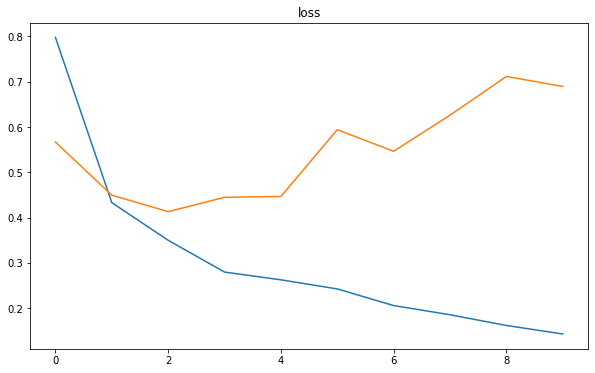

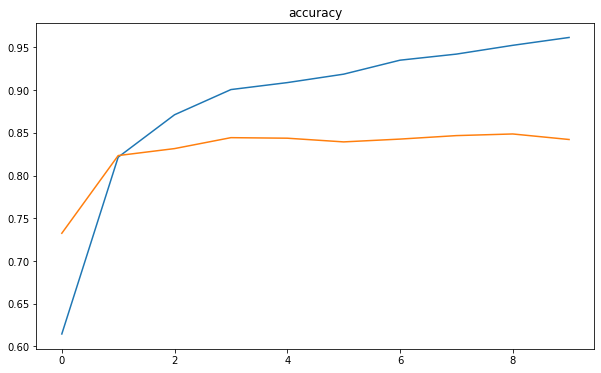

In [27]:
# GRU - complete with model definition, summary, fit and plots.


model_gru = keras.models.Sequential()
model_gru.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_gru.add(keras.layers.GRU(25))
model_gru.add(keras.layers.Dense(1, activation="tanh"))

model_gru.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])


# Model summary

model_gru.summary()


# Train the model

history = model_gru.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

#Plot

plot_loss(history)

plot_accuracy(history)

scores = model_lstm.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_lstm.metrics_names[1], scores[1]*100))

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use?

**Insert cells (code and text) with results and discussion immediately after this cell** 



#### LSTM Model

Firstly I tried training the model with 25 units on the LSTM layer. This used a total amount of params. 103,626 to train. An accuracy of 85.51% was reached, however great increasing in loss was noted. To train the model spent less than 20 seconds per epoch. To start I keep all other parameters the same as my previous model.
Next I tried using 18 units for the LSTM layer. Trainable params: 102,107, accuracy: 86.42%, loss: 0.4250 and still training time less than 20s per epoch. In all this performed better than the previous and the resulted curve was way smoother.
After I tried with 32 units for the LSTM layer. Trainable params: 105,537, accuracy: 85.98% , loss: 0.4767 and training time in average 18s per epoch.  Overfitting is present in all of the tries.
Since the best performing model is with 18 units I continued with this one and changed the activation function to relu, with this change the model showed bigger loss and lower accuracy, it's obvious that it is not the right direction to follow. Trainable params: 102,107, accuracy: 81.42%, loss: 0.5626 and a very unstable curve. Following using the same model I change the activation function to tanh. With this Trainable params: 103,626, accuracy: 84.59%. Training time still keeping at 18 seconds per epoch.


#### GRU Model

For the GRU Model I followed the same patern. 
First I tried 25 units for the GRU layer.Trainable params: 103,626, accuracy: 86.49% and it takes around 21s per epoch to train. 
Then trying with 18 units for the GRU layer. Trainable params: 101,639, accuracy: 85.35%. It took approximately 18 seconds per epoch and the overfitting was present. Next model was with 32 units. Trainable params: 104,257, accuracy: 84.94% and 23s per epoch for the training. Overffiting still was present.
Going forward with the model with 25 units on GRU layer and changing the activation function to relu. Trainable params: 102,801, accuracy: 85.27%.
Lastly I tried changing the activation function to tanh and got Trainable params: 102,801, accuracy: 84.59% The model needed around 18s to train per epoch.

As a conclusion in order to perform a fair comparison between the models, they both have to use 25 units so we can achieve trainable parameters: 103,626.

**Comparison between the simple RNN and LSTM and GRU**
To conclude the models did not reach to very different results, however there was a significant difference in the training time. The simple RNN took more than double the time to train the model. They use different number of units to reach best performance. 




### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [14]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 11s 43ms/step - loss: 0.5403 - accuracy: 0.7149 - val_loss: 0.3779 - val_accuracy: 0.8483
Epoch 2/5
196/196 [==============================] - 8s 39ms/step - loss: 0.2783 - accuracy: 0.8908 - v

391/391 - 5s - loss: 0.3340 - accuracy: 0.8739 - 5s/epoch - 12ms/step
accuracy: 87.39%


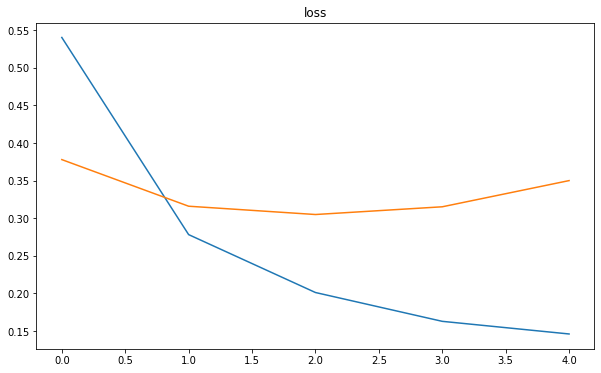

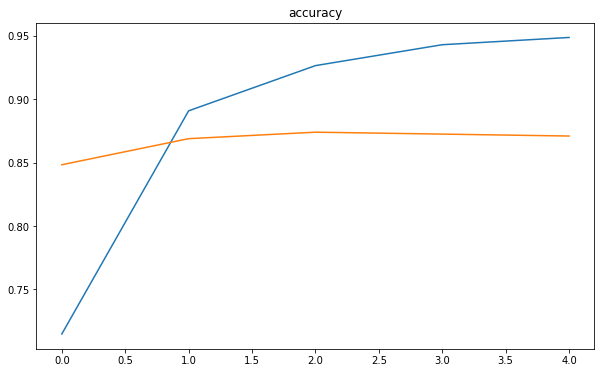

In [15]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [16]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [17]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [18]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


**[TO COMPLETE]** Experiment with the `embed_dim, num_heads, ff_dim` and discuss the influence of these parameters in the obtained results, considering the accuracy of the output at the time required to perform the training phase. Report the discussion in the cell at the end of the notebook.

In [19]:
embed_dim = 30  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 3  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)



Epoch 1/5
196/196 [==============================] - 6s 23ms/step - loss: 0.4647 - accuracy: 0.7623 - val_loss: 0.3092 - val_accuracy: 0.8669
Epoch 2/5
196/196 [==============================] - 4s 22ms/step - loss: 0.2408 - accuracy: 0.9063 - val_loss: 0.3026 - val_accuracy: 0.8716
Epoch 3/5
196/196 [==============================] - 4s 21ms/step - loss: 0.1824 - accuracy: 0.9340 - val_loss: 0.3717 - val_accuracy: 0.8562
Epoch 4/5
196/196 [==============================] - 4s 21ms/step - loss: 0.1522 - accuracy: 0.9471 - val_loss: 0.4285 - val_accuracy: 0.8390
Epoch 5/5
196/196 [==============================] - 4s 22ms/step - loss: 0.1317 - accuracy: 0.9547 - val_loss: 0.4099 - val_accuracy: 0.8592


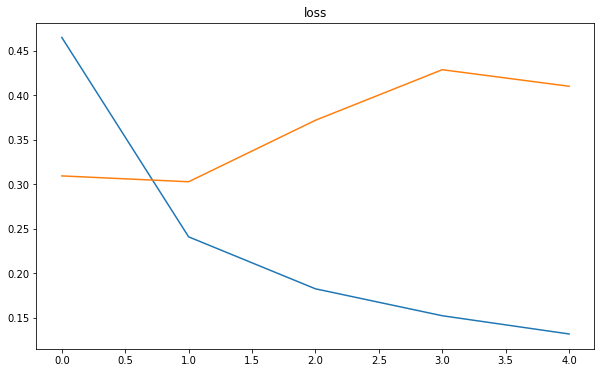

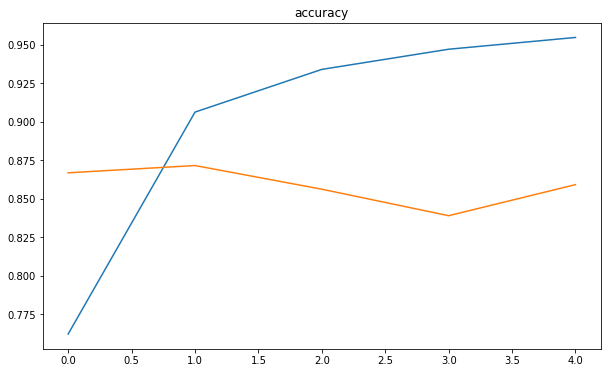

In [21]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

**Insert the discussion here**: 

I experimented with different numberes of embed_dim, num_heads and ff_dim. For the embedding size for each token I tried changing the numbers from 30, 32 and 35. with the same combination for the hidden layer size. For the number of heads I took variation from 1 to 3. The best showing performance was with using 3 for the number of head and lower numbers for embed_dim and ff_dim.  
The accuracy varied from 83,54% for the values embed_dim = 35, num_heads = 3, ff_dim = 35 and up to 85,74% for embed_dim = 30, num_heads = 3, ff_dim = 30.
